In [22]:
import typing

import cltrier_nlp as nlp

import numpy as np
import pandas as pd

from datasets import load_dataset

from sklearn.decomposition import PCA

import plotly
import plotly.graph_objs as go

import tqdm
import requests

In [36]:
encoder_type: str = "local"
SAMPLE_SIZE: int = 500

In [24]:
dataset = pd.DataFrame(load_dataset("stanfordnlp/imdb").shuffle()["train"][:SAMPLE_SIZE])
dataset

,text,label
0,"Debbie Reynolds toe-taps, tangos and, yes, tap...",0
1,No movie with Madeleine Carroll in its cast co...,0
2,"Sure, for it's super imagery and awesome sound...",1
3,This movie was almost intolerable to sit throu...,0
4,This movie was extremely depressing. <br /><br...,0
...,...,...
495,I love this movie. I mean the story may not be...,1
496,I almost burst into tears watching this movie....,0
497,"Woody Allen, when at his best, has one of the ...",0
498,"But the opposite, sorry bud, i completely unde...",1


In [41]:
def local_encoding(data: pd.Series) -> typing.List:
    return [
        embed.detach().numpy() 
        for embed in 
        nlp.encoder.EncoderPooler()(
            nlp.encoder.Encoder()(data.tolist()), 
            form="sent_cls")
    ]

In [42]:
def remote_encoding(data: pd.Series) -> typing.List:
    embeds: typing.Dict[str, np.ndarray] = {}

    for index, value in tqdm.tqdm(data.items(), total=len(data)):
    
        if index in embeds.keys():
            continue
            
        try: 
            embed = np.array(requests.post(
                'https://inf.cl.uni-trier.de/embed/',
                json={'prompt': value}
            ).json()["response"])
            
        except Exception as _e:
            display(_e)
            embed = None
        
        embeds[index] = embed

    return embeds

In [43]:
ENCODER: typing.Dict[str, typing.Callable] = {
    "local": local_encoding,
    "remote": remote_encoding,
}

In [44]:
dataset["embeds"] = ENCODER[encoder_type](dataset["text"])
dataset.head()

,text,label,embeds,embeds_n3
0,"Debbie Reynolds toe-taps, tangos and, yes, tap...",0,"[-1.2736816, -0.2802925, -4.90646, -1.02809, 0...","[0.4736510710230753, 0.07599819756358014, 3.87..."
1,No movie with Madeleine Carroll in its cast co...,0,"[-0.07817702, -0.7175811, -4.215266, -0.543895...","[-3.041047504531214, -3.601452490190951, 1.451..."
2,"Sure, for it's super imagery and awesome sound...",1,"[-0.318833, -0.08746876, -4.4978223, -0.954919...","[-3.828892625860559, -0.2069170209034576, -2.5..."
3,This movie was almost intolerable to sit throu...,0,"[-0.3510294, -0.24127027, -4.635813, -1.080975...","[2.3495481472572997, -0.3214843987187871, 1.21..."
4,This movie was extremely depressing. <br /><br...,0,"[-0.7606629, -0.11146136, -4.6705503, -1.27465...","[2.2620092065879156, -1.1822532073939132, -1.2..."


In [29]:
dataset

,text,label,embeds
0,"Debbie Reynolds toe-taps, tangos and, yes, tap...",0,None
1,No movie with Madeleine Carroll in its cast co...,0,None
2,"Sure, for it's super imagery and awesome sound...",1,None
3,This movie was almost intolerable to sit throu...,0,None
4,This movie was extremely depressing. <br /><br...,0,None
...,...,...,...
495,I love this movie. I mean the story may not be...,1,None
496,I almost burst into tears watching this movie....,0,None
497,"Woody Allen, when at his best, has one of the ...",0,None
498,"But the opposite, sorry bud, i completely unde...",1,None


In [45]:
dataset["embeds_n3"] = list(PCA(n_components=3).fit_transform(dataset["embeds"].tolist()))
dataset.head()

,text,label,embeds,embeds_n3
0,"Debbie Reynolds toe-taps, tangos and, yes, tap...",0,"[-1.2736816, -0.2802925, -4.90646, -1.02809, 0...","[0.716236991047304, -0.20964168652999363, 0.88..."
1,No movie with Madeleine Carroll in its cast co...,0,"[-0.07817702, -0.7175811, -4.215266, -0.543895...","[1.7570655423886068, -2.034311185882602, -2.26..."
2,"Sure, for it's super imagery and awesome sound...",1,"[-0.318833, -0.08746876, -4.4978223, -0.954919...","[1.0029280466489823, -0.4756553896309977, -1.3..."
3,This movie was almost intolerable to sit throu...,0,"[-0.3510294, -0.24127027, -4.635813, -1.080975...","[2.771197886515013, 1.5228184148289474, -0.552..."
4,This movie was extremely depressing. <br /><br...,0,"[-0.7606629, -0.11146136, -4.6705503, -1.27465...","[-2.4691406866528904, -0.2025594541576548, 2.9..."


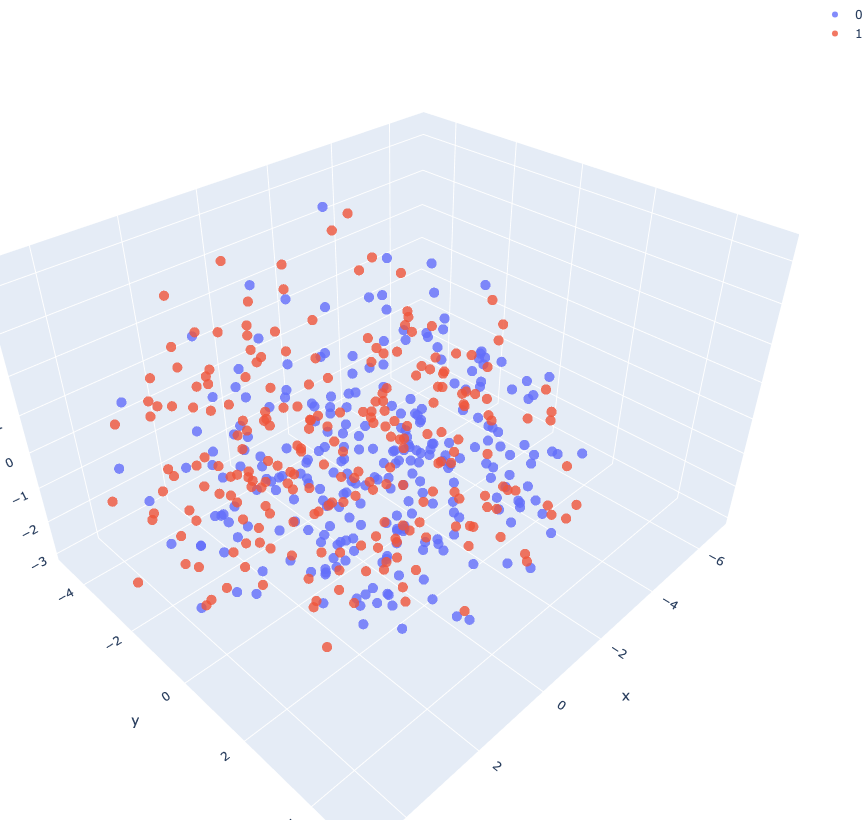

In [46]:
plotly.offline.iplot(
    go.Figure(
        data=[
                go.Scatter3d(
                **{
                    dim: group["embeds_n3"].str[idx].tolist() 
                    for idx, dim in enumerate(["x", "y", "z"])
                },
                text = group["text"],
                name=label,
                mode='markers',
                marker={
                    'size': 6,
                    'opacity': 0.8,
                }
            )
            for label, group in dataset.groupby("label")
        ], 
        layout=go.Layout(
            margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
            height=820
        )
    )
)